In [310]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import sklearn.metrics as met
import matplotlib.pyplot as plt
import seaborn
from sklearn.svm import SVC
from scipy import signal
import itertools



from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


In [320]:
X_train = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Train/X_train.txt")
X_test = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Test/X_test.txt")
Y_train = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Train/y_train.txt")
Y_test = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Test/y_test.txt")

In [321]:
X = np.vstack((X_train, X_test))
Y = np.hstack((Y_train, Y_test))

In [322]:
X.shape

(10929, 561)

In [323]:
1958+70

2028

In [324]:
np.unique(Y, return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 array([1722, 1544, 1407, 1801, 1979, 1958,   70,   33,  107,   85,  139,
          84]))

In [7]:
feature_names = np.genfromtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/features.txt",dtype='str')
#features, counts = np.unique(feature_names, return_counts=True)
#features[np.where(counts>1)]

In [8]:
label_names = np.genfromtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/activity_labels.txt", dtype='str')
label_names = [l[1] for l in label_names ]
label_names

['WALKING',
 'WALKING_UPSTAIRS',
 'WALKING_DOWNSTAIRS',
 'SITTING',
 'STANDING',
 'LAYING',
 'STAND_TO_SIT',
 'SIT_TO_STAND',
 'SIT_TO_LIE',
 'LIE_TO_SIT',
 'STAND_TO_LIE',
 'LIE_TO_STAND']

In [9]:
al_labels=['WALKING',
         'WALKING_UPSTAIRS',
         'WALKING_DOWNSTAIRS',
         'SITTING',
         'STANDING',
         'LAYING']
atl_labels=['STAND_TO_SIT',
         'SIT_TO_STAND',
         'SIT_TO_LIE',
         'LIE_TO_SIT',
         'STAND_TO_LIE',
         'LIE_TO_STAND']

In [10]:
Y_onehot=[]
for l in Y:
    empty_label=np.zeros(len(label_names))
    empty_label[int(l)-1]=1.
    Y_onehot.append(empty_label)
Y_onehot=np.vstack(Y_onehot)

In [11]:
#Y_al = Y_onehot[:, np.isin(label_names, al_labels)]
#Y_atl = Y_onehot[:, np.isin(label_names, atl_labels)]

In [12]:
al_idx = np.where(Y<=6)
atl_idx = np.where(Y>6)

X_al = X[al_idx]
X_atl = X[atl_idx]
Y_al = Y[al_idx]
Y_atl = Y[atl_idx]

In [13]:
train_uid = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Train/subject_id_train.txt")
test_uid = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Test/subject_id_test.txt")
user_ids = np.hstack((train_uid, test_uid))

In [14]:
rand_uid=[np.random.choice(np.unique(user_ids), len(np.unique(user_ids)), replace=False) for _ in range(5)]
rand_uid

[array([13., 22., 29.,  1., 27., 24., 17., 28., 10.,  9., 30., 21., 20.,
         5., 12., 18., 26.,  8.,  7.,  6., 14.,  4., 23., 16., 25., 15.,
         3.,  2., 11., 19.]),
 array([21., 23.,  3., 22., 11., 16., 29., 19., 12., 26.,  1., 28.,  2.,
        14., 15., 25., 27.,  8., 13., 20., 24.,  7.,  4.,  5., 17.,  9.,
         6., 18., 10., 30.]),
 array([11., 10., 26., 19., 17., 24., 27.,  6., 16.,  5.,  9., 29., 12.,
        23.,  7., 22., 30.,  1., 21., 15., 20., 25., 13.,  2., 14., 28.,
        18.,  8.,  3.,  4.]),
 array([ 8., 28., 17., 19., 18.,  1., 29., 22., 26.,  5.,  4., 24.,  6.,
        14., 25.,  7., 16., 21.,  9., 10., 27., 30., 12.,  2.,  3., 13.,
        20., 15., 23., 11.]),
 array([ 8., 15.,  2., 27., 19., 18.,  7., 26., 12., 10., 23., 13., 22.,
        29., 30.,  3., 17., 24., 16.,  4., 21., 14., 28., 20., 25.,  9.,
         6., 11.,  5.,  1.])]

## Y - all Labels - User 28

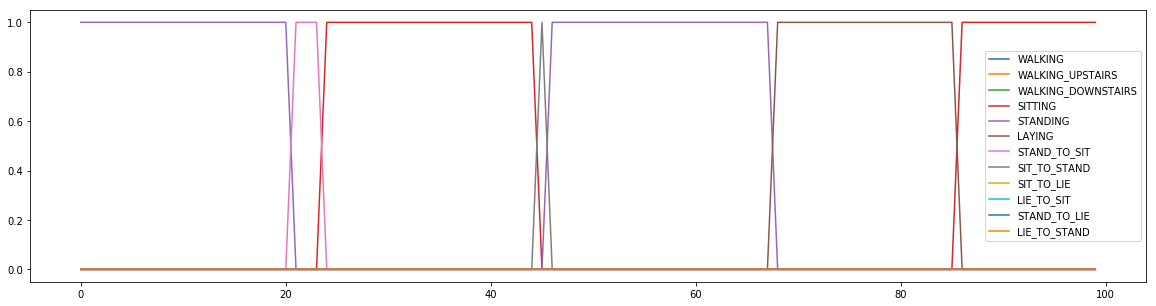

In [29]:
ind_user=Y[np.isin(user_ids, [28])]
ind_y_conv=[]
for l in ind_user:
    empty_label=np.zeros(len(label_names))
    empty_label[int(l)-1]=1.
    ind_y_conv.append(empty_label)
ind_y_conv=np.vstack(ind_y_conv)

plt.figure(figsize=(20,5))
plt.plot(ind_y_conv[:100])
plt.legend(label_names)
plt.show()

## XGBoost - All Labels

In [162]:
for cv_idx, cv_fold in enumerate(rand_uid):
    train_ids, test_ids = cv_fold[:int(0.7*len(cv_fold))], cv_fold[int(0.7*len(cv_fold)):]
    train_idx = np.isin(user_ids, train_ids)
    test_idx = np.isin(user_ids, test_ids)
    cv_x_train = X[train_idx]
    cv_y_train = Y[train_idx]
    cv_x_test = X[test_idx]
    cv_y_test = Y[test_idx]
    xgb_model=XGBClassifier()
    xgb_model.fit(cv_x_train, cv_y_train)
    xgb_y_hat = xgb_model.predict(cv_x_test)
    print(1.-accuracy_score(xgb_y_hat, cv_y_test))
    #break

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.06468266018827817


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.09206349206349207


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.1157407407407407


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.031134401972872983
0.095649490897871


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


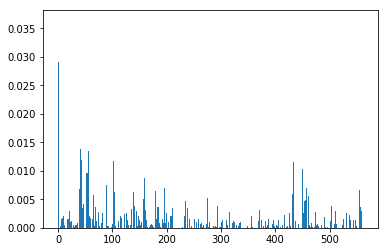

In [214]:
plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
plt.show()

In [219]:
top_features=(-xgb_model.feature_importances_).argsort()[:10]
print(feature_names[top_features])
print(xgb_model.feature_importances_[top_features])

['tBodyAcc-Mean-1' 'tBodyAcc-Mean-2' 'tBodyAcc-Correlation-1'
 'tGravityAcc-Min-2' 'tBodyAcc-Max-1' 'tGravityAcc-Max-1'
 'tGravityAcc-Mean-2' 'tGravityAcc-Energy-1' 'fBodyAcc-BandsEnergyOld-1'
 'tGravityAcc-STD-1']
[0.03634004 0.02903958 0.02044127 0.01735886 0.01589877 0.01427644
 0.01378975 0.01346528 0.01216742 0.01184296]


Text(0.5,1,'XGB')

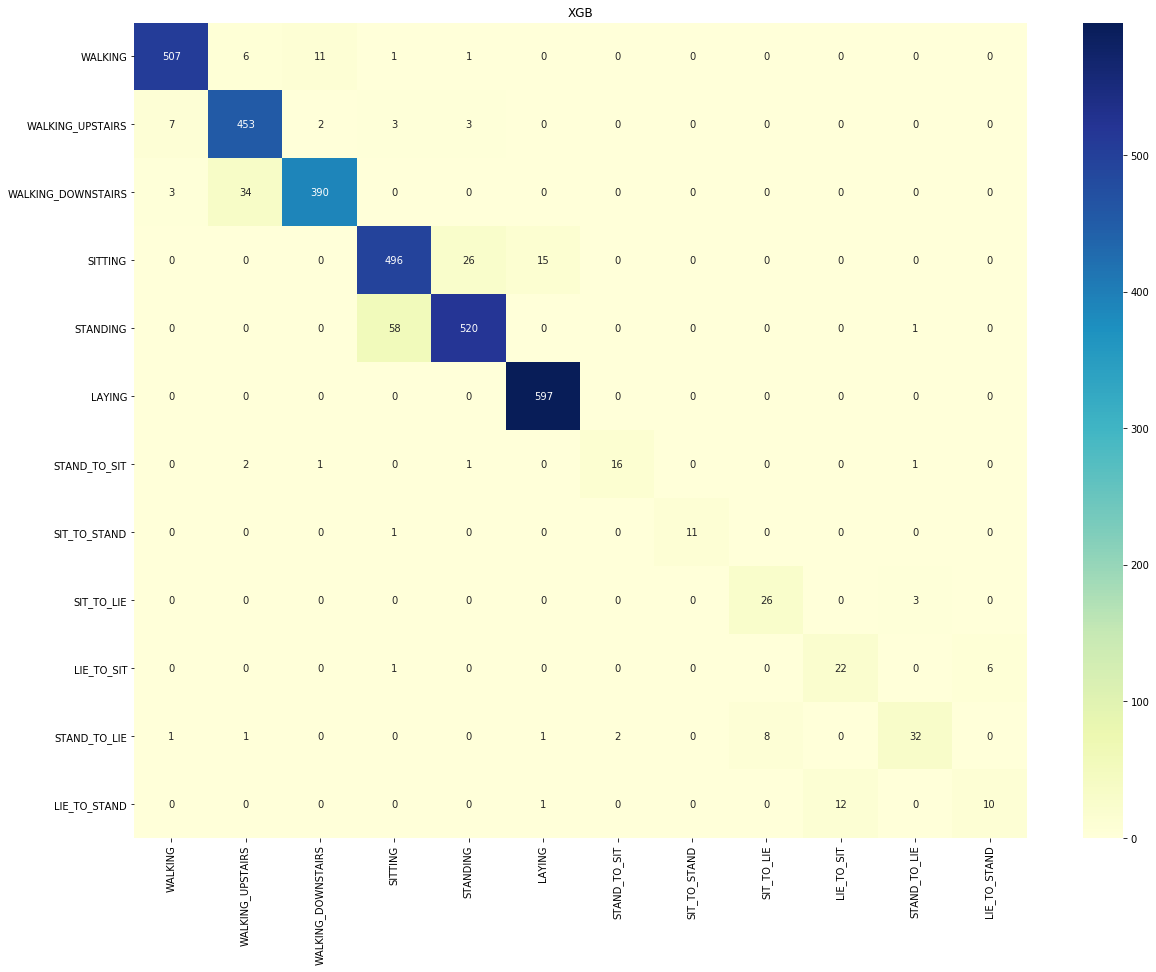

In [90]:
xgb_result_conf_mat = met.confusion_matrix(cv_y_test, xgb_y_hat)
plt.subplots(figsize=(20,15))
s=seaborn.heatmap(xgb_result_conf_mat.astype(int), annot=True, cmap="YlGnBu", fmt='d', xticklabels=label_names, yticklabels=label_names)
title="XGB"
s.set_title(title)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


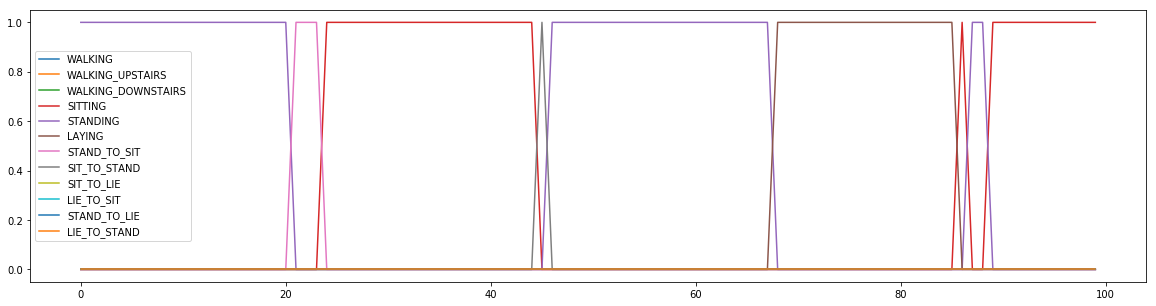

In [73]:
ind_user=X[np.isin(user_ids, [28])]
ind_user=xgb_model.predict(ind_user)
ind_y_hat_conv=[]
for l in ind_user:
    empty_label=np.zeros(len(label_names))
    empty_label[int(l)-1]=1.
    ind_y_hat_conv.append(empty_label)
ind_y_hat_conv=np.vstack(ind_y_hat_conv)
plt.figure(figsize=(20,5))
plt.plot(ind_y_hat_conv[:100])
plt.legend(label_names)
plt.show()

## SVC All Labels

In [164]:
for cv_idx, cv_fold in enumerate(rand_uid):
    train_ids, test_ids = cv_fold[:int(0.7*len(cv_fold))], cv_fold[int(0.7*len(cv_fold)):]
    train_idx = np.isin(user_ids, train_ids)
    test_idx = np.isin(user_ids, test_ids)
    cv_x_train = X[train_idx]
    cv_y_train = Y[train_idx]
    cv_x_test = X[test_idx]
    cv_y_test = Y[test_idx]
    svc_model=SVC(gamma='auto', probability=True)
    svc_model.fit(cv_x_train, cv_y_train)
    #y_hat = svc_model.predict_proba(cv_x_test)
    svc_y_hat = svc_model.predict(cv_x_test)
    print(1.-accuracy_score(np.round(svc_y_hat), cv_y_test))
    #break

0.08958396598846041
0.1212698412698413
0.1274691358024691
0.049630086313193544
0.12897253933970998


Text(0.5,1,'SVM')

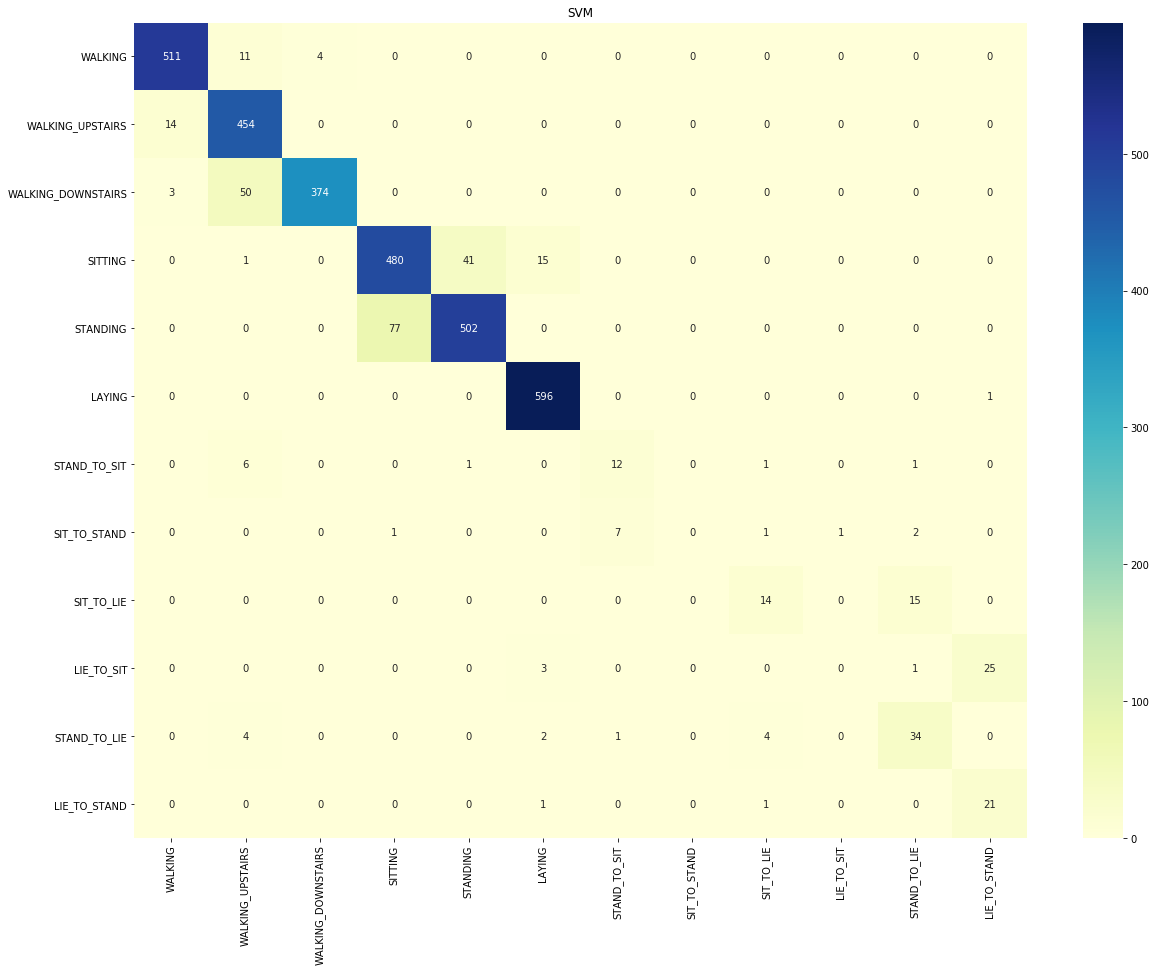

In [92]:
svc_result_conf_mat = met.confusion_matrix(cv_y_test, svc_y_hat)
plt.subplots(figsize=(20,15))
s=seaborn.heatmap(svc_result_conf_mat.astype(int), annot=True, cmap="YlGnBu", fmt='d', xticklabels=label_names, yticklabels=label_names)
title="SVM"
s.set_title(title)

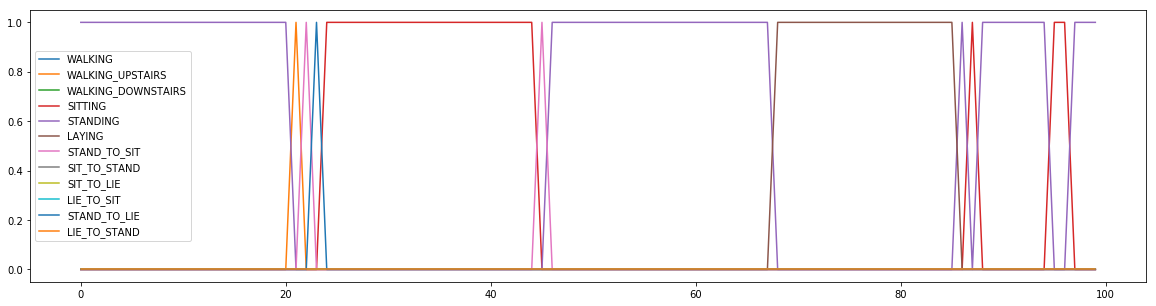

In [76]:
ind_user=X[np.isin(user_ids, [28])]
ind_user=svc_model.predict(ind_user)
ind_y_hat_conv=[]
for l in ind_user:
    empty_label=np.zeros(len(label_names))
    empty_label[int(l)-1]=1.
    ind_y_hat_conv.append(empty_label)
ind_y_hat_conv=np.vstack(ind_y_hat_conv)
plt.figure(figsize=(20,5))
plt.plot(ind_y_hat_conv[:100])
plt.legend(label_names)
plt.show()

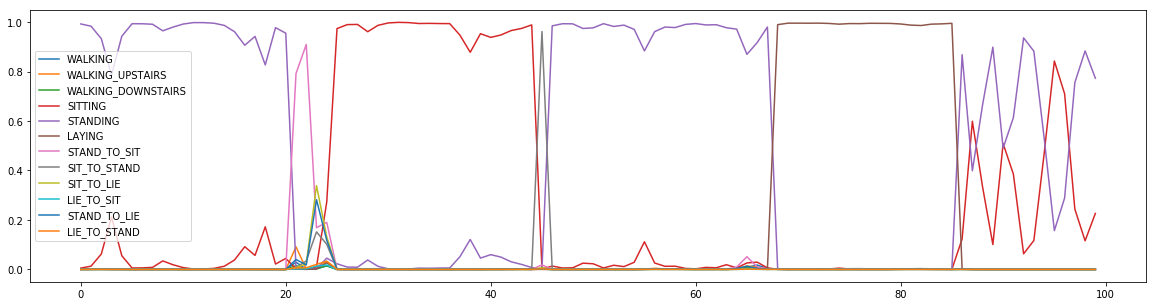

In [77]:
ind_user=X[np.isin(user_ids, [28])]
ind_user=svc_model.predict_proba(ind_user)
ind_y_hat_conv=ind_user
plt.figure(figsize=(20,5))
plt.plot(ind_y_hat_conv[:100])
plt.legend(label_names, loc='center left')
plt.show()

### SVC  - Only Activity learning

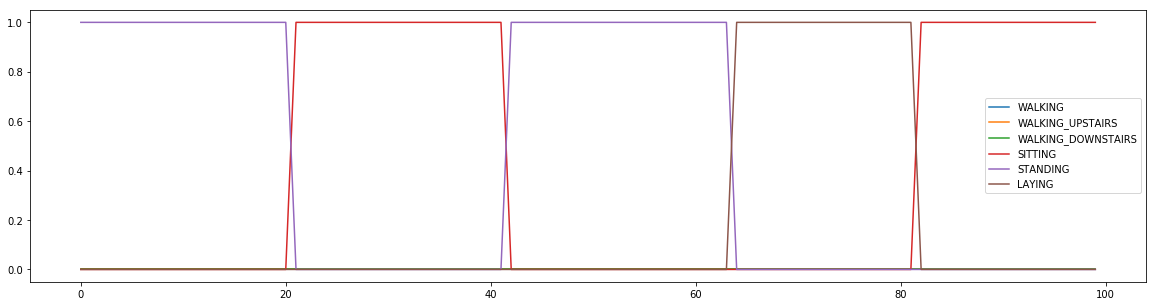

In [78]:
ind_user=Y_al[np.isin(user_ids, [28])[al_idx]]
ind_y_conv=[]
for l in ind_user:
    empty_label=np.zeros(len(al_labels))
    empty_label[int(l)-1]=1.
    ind_y_conv.append(empty_label)
ind_y_conv=np.vstack(ind_y_conv)

plt.figure(figsize=(20,5))
plt.plot(ind_y_conv[:100])
plt.legend(al_labels)
plt.show()

In [165]:
for cv_idx, cv_fold in enumerate(rand_uid):
    train_ids, test_ids = cv_fold[:int(0.7*len(cv_fold))], cv_fold[int(0.7*len(cv_fold)):]
    train_idx = np.isin(user_ids, train_ids)[al_idx]
    test_idx = np.isin(user_ids, test_ids)[al_idx]
    cv_x_train = X_al[train_idx]
    cv_y_train = Y_al[train_idx]
    cv_x_test = X_al[test_idx]
    cv_y_test = Y_al[test_idx]
    svc_model=SVC(gamma='auto', probability=True)
    svc_model.fit(cv_x_train, cv_y_train)
    #y_hat = svc_model.predict_proba(cv_x_test)
    svc_y_hat = svc_model.predict(cv_x_test)
    print(1.-accuracy_score(np.round(svc_y_hat), cv_y_test))
    #break

0.06860242501595404
0.10120240480961928
0.10677083333333337
0.030794165316045397
0.10680560078150436


Text(0.5,1,'SVM')

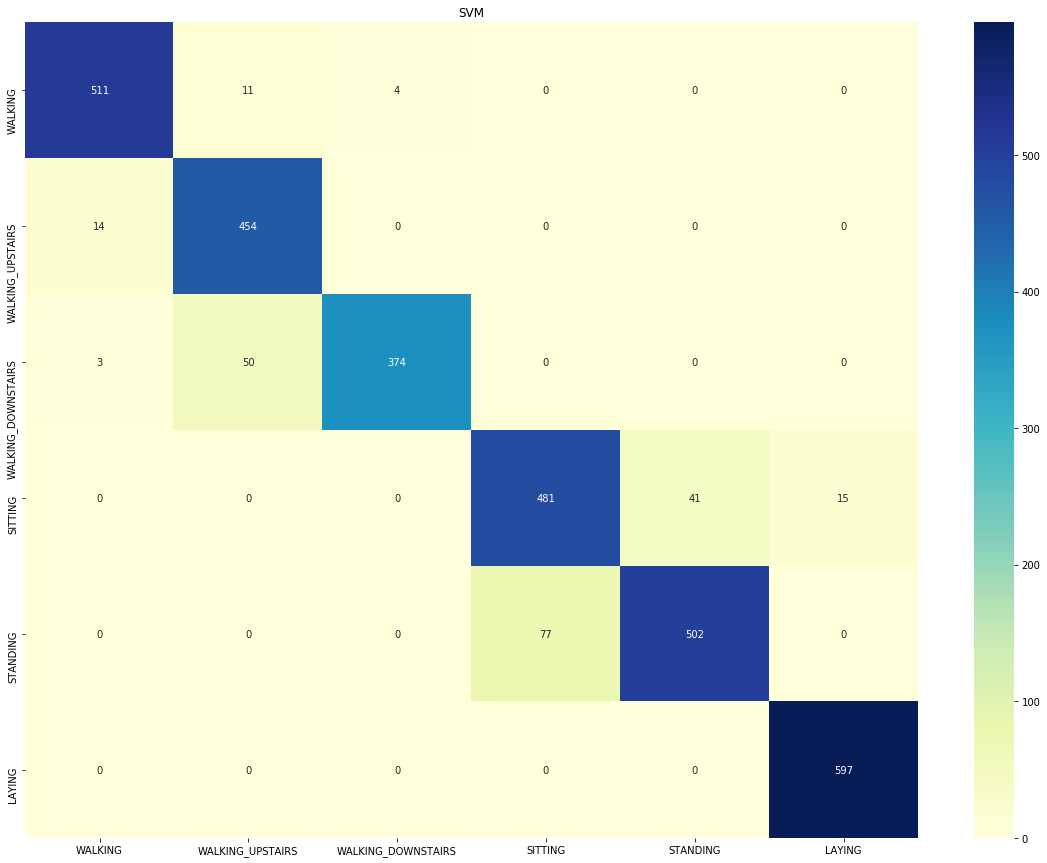

In [94]:
svc_result_conf_mat = met.confusion_matrix(cv_y_test, svc_y_hat)
plt.subplots(figsize=(20,15))
s=seaborn.heatmap(svc_result_conf_mat.astype(int), annot=True, cmap="YlGnBu", fmt='d', xticklabels=al_labels, yticklabels=al_labels)
title="SVM"
s.set_title(title)

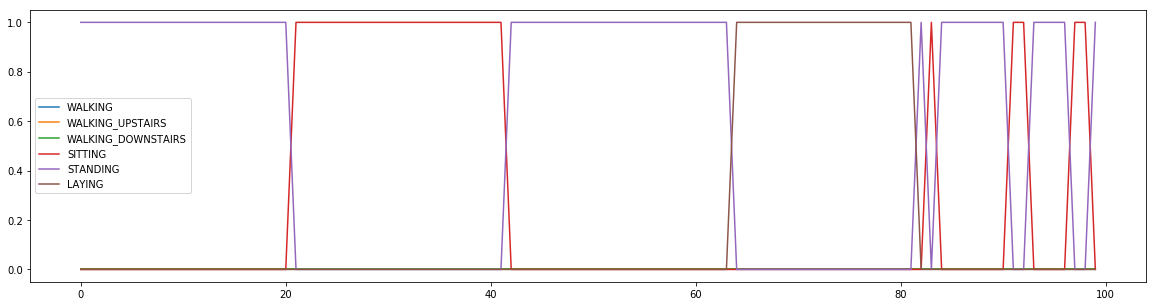

In [81]:
ind_user=X_al[np.isin(user_ids, [28])[al_idx]]
ind_user=svc_model.predict(ind_user)
ind_y_hat_conv=[]
for l in ind_user:
    empty_label=np.zeros(len(al_labels))
    empty_label[int(l)-1]=1.
    ind_y_hat_conv.append(empty_label)
ind_y_hat_conv=np.vstack(ind_y_hat_conv)
plt.figure(figsize=(20,5))
plt.plot(ind_y_hat_conv[:100])
plt.legend(al_labels)
plt.show()

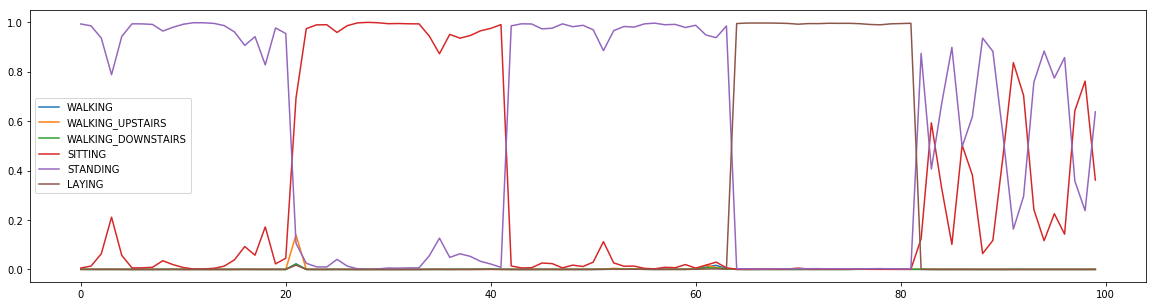

In [82]:
ind_user=X_al[np.isin(user_ids, [28])[al_idx]]
ind_user=svc_model.predict_proba(ind_user)
ind_y_hat_conv=ind_user
plt.figure(figsize=(20,5))
plt.plot(ind_y_hat_conv[:100])
plt.legend(label_names, loc='center left')
plt.show()

## SVC - Only Activity transitions

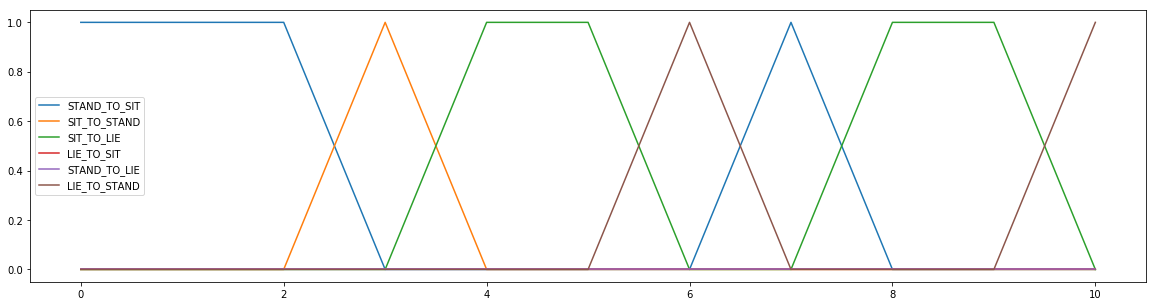

In [36]:
ind_user=Y_atl[np.isin(user_ids, [28])[atl_idx]]
ind_y_conv=[]
for l in ind_user:
    empty_label=np.zeros(len(atl_labels))
    empty_label[int(l)-7]=1.
    ind_y_conv.append(empty_label)
ind_y_conv=np.vstack(ind_y_conv)

plt.figure(figsize=(20,5))
plt.plot(ind_y_conv[:100])
plt.legend(atl_labels)
plt.show()

In [166]:
for cv_idx, cv_fold in enumerate(rand_uid):
    train_ids, test_ids = cv_fold[:int(0.7*len(cv_fold))], cv_fold[int(0.7*len(cv_fold)):]
    train_idx = np.isin(user_ids, train_ids)[atl_idx]
    test_idx = np.isin(user_ids, test_ids)[atl_idx]
    cv_x_train = X_atl[train_idx]
    cv_y_train = Y_atl[train_idx]
    cv_x_test = X_atl[test_idx]
    cv_y_test = Y_atl[test_idx]
    svc_model=SVC(gamma='auto', probability=True)
    svc_model.fit(cv_x_train, cv_y_train)
    #y_hat = svc_model.predict_proba(cv_x_test)
    svc_y_hat = svc_model.predict(cv_x_test)
    print(1.-accuracy_score(np.round(svc_y_hat), cv_y_test))
    break

0.42138364779874216
0.4358974358974359
0.43452380952380953
0.37735849056603776
0.40588235294117647


Text(0.5,1,'SVM')

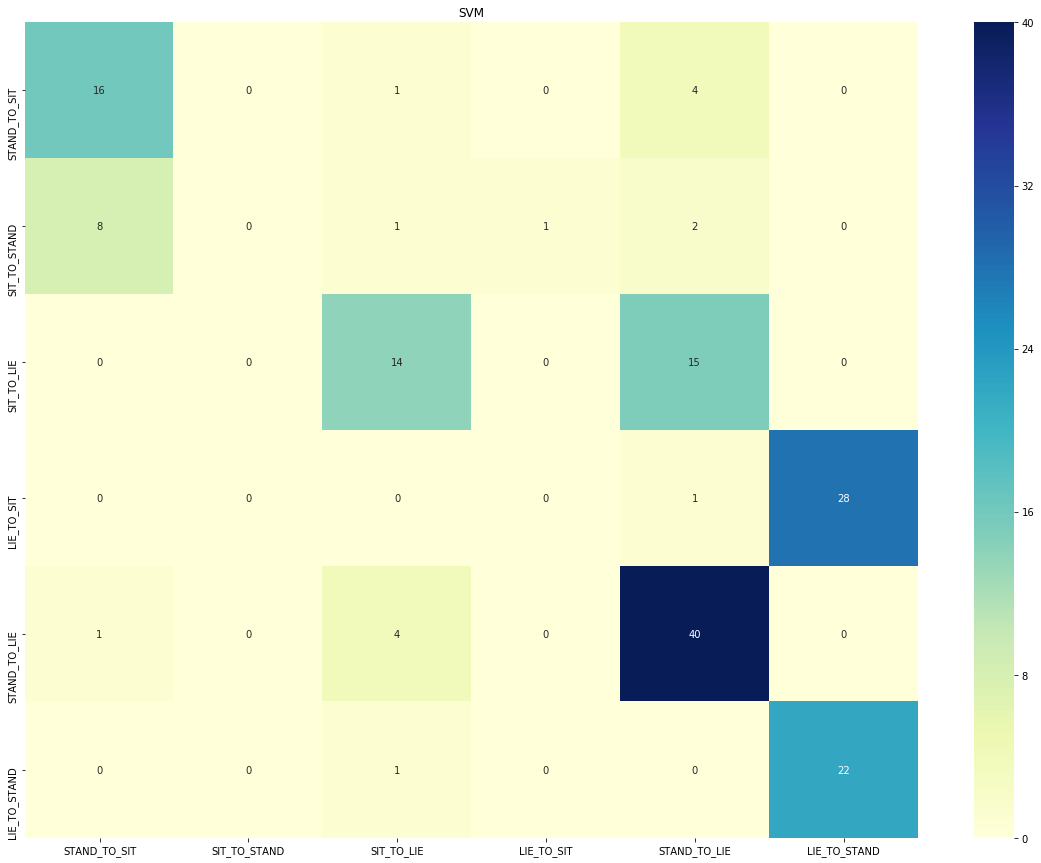

In [96]:
svc_result_conf_mat = met.confusion_matrix(cv_y_test, svc_y_hat)
plt.subplots(figsize=(20,15))
s=seaborn.heatmap(svc_result_conf_mat.astype(int), annot=True, cmap="YlGnBu", fmt='d', xticklabels=atl_labels, yticklabels=atl_labels)
title="SVM"
s.set_title(title)

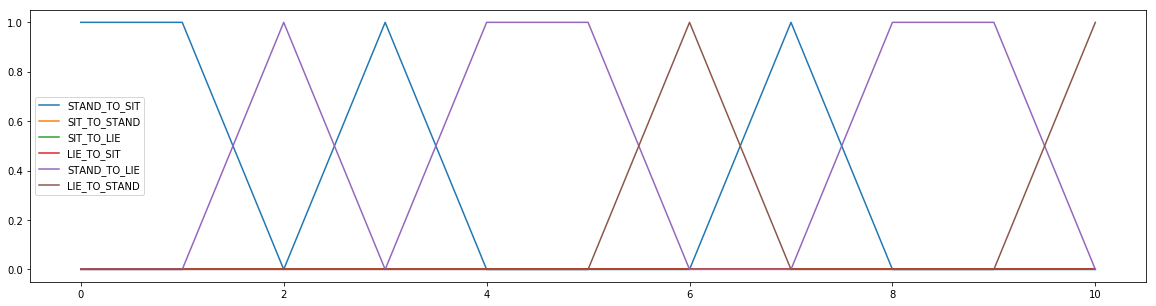

In [85]:
ind_user=X_atl[np.isin(user_ids, [28])[atl_idx]]
ind_user=svc_model.predict(ind_user)
ind_y_hat_conv=[]
for l in ind_user:
    empty_label=np.zeros(len(atl_labels))
    empty_label[int(l)-7]=1.
    ind_y_hat_conv.append(empty_label)
ind_y_hat_conv=np.vstack(ind_y_hat_conv)
plt.figure(figsize=(20,5))
plt.plot(ind_y_hat_conv[:100])
plt.legend(atl_labels)
plt.show()

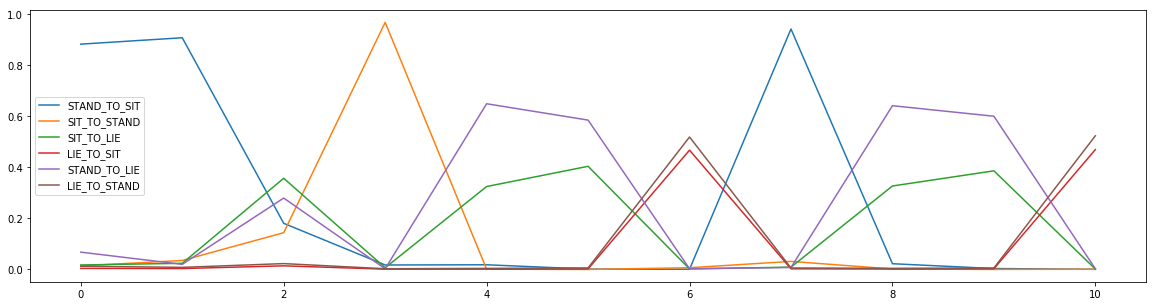

In [86]:
ind_user=X_atl[np.isin(user_ids, [28])[atl_idx]]
ind_user=svc_model.predict_proba(ind_user)
ind_y_hat_conv=ind_user
plt.figure(figsize=(20,5))
plt.plot(ind_y_hat_conv[:100])
plt.legend(atl_labels, loc='center left')
plt.show()

In [312]:
def process_metrics(target, output):    
    def get_metrics(target, output):
        
        pred = np.round(output)
        
        tp = np.sum(((pred + target) == 2).astype(float), axis=0)
        fp = np.sum(((pred - target) == 1).astype(float), axis=0)
        fn = np.sum(((pred - target) == -1).astype(float), axis=0)
        tn = np.sum(((pred + target) == 0).astype(float), axis=0)

        acc = (tp + tn) / (tp + tn + fp + fn)
        try:
            prec = tp / (tp + fp)
        except ZeroDivisionError:
            prec = 0.0
        try:
            rec = tp / (tp + fn)
        except ZeroDivisionError:
            rec = 0.0
        try:
            specificity = tn / (tn + fp)
        except ZeroDivisionError:
            specificity = 0.0


        try:
            f1=2.*((prec*rec)/(prec+rec))
        except ZeroDivisionError:
            f1 = 0.0
        
        acc[acc != acc] = 0.
        prec[prec != prec] = 0.
        rec[rec != rec] = 0.
        specificity[specificity != specificity] = 0.
        f1[f1 != f1] = 0.
        
        balanced_accuracy = (rec + specificity) / 2.
        
        f1_micro, f1_macro, f1_weight, log_ls, roc = [], [], [], [], []
        for idx in range(target.shape[1]):
            y_test=target[:,idx]
            y_pred=pred[:,idx]
            
            f1_micro.append(f1_score(y_test, y_pred, average= 'micro'))
            f1_macro.append(f1_score(y_test, y_pred, average= 'macro'))
            f1_weight.append(f1_score(y_test, y_pred, average= 'weighted'))
            log_ls.append(log_loss(y_test, y_pred, labels=[0., 1.]))
            try:
                roc.append(roc_auc_score(y_test, output[:, idx]))
            except ValueError:
                roc.append(np.nan)

        return (balanced_accuracy, acc, prec, rec, specificity, f1, tp, fp, fn, tn, np.array(f1_micro), np.array(f1_macro), np.array(f1_weight), np.array(log_ls), np.array(roc))
    
    y_hat_onehot = one_hot(y_hat)
    y_true_onehot = one_hot(CV_Y_test)       
    results_conf_mat = met.confusion_matrix(CV_Y_test, y_hat)
    results_metrics = get_metrics(y_true_onehot, svc_y_hat_prob)
    metric_names = np.array(["CV", "Balanced Accuracy", "Accuracy","Precision","Recall","Specificity", "F1", "TP","FP","FN","TN", "Micro F1","Macro F1","Weighted F1","Log-Loss","ROC AUC"])
    results = np.hstack((metric_names.reshape(-1, 1), np.vstack((atl_labels, np.vstack(results_metrics)))))
    with open("ATL_classification_results_SVC_Baseline.csv", 'a') as f:
        pd.DataFrame(results).to_csv(f, header=False)
            
    plt.subplots(figsize=(20,15))
    s=seaborn.heatmap(results_conf_mat.astype(int), annot=True, cmap="YlGnBu", fmt='d', xticklabels=atl_labels, yticklabels=atl_labels)
    title="Activity Transition Learning"
    s.set_title(title)

In [314]:
def one_hot(y):
        Y_onehot=[]
        labels=np.unique(y)
        for l in y:
            empty_label=np.zeros(len(labels))
            empty_label[int(l)-1]=1.
            Y_onehot.append(empty_label)
        return(np.vstack(Y_onehot))
    

## SVC - ATL - Transition as one class

In [105]:
Y_ATL=Y.copy()
Y_ATL[atl_idx] = 7
ATL_label_names=al_labels+["TRANSITION"]

In [ ]:
for cv_idx, cv_fold in enumerate(rand_uid):
    train_ids, test_ids = cv_fold[:int(0.7*len(cv_fold))], cv_fold[int(0.7*len(cv_fold)):]
    train_idx = np.isin(user_ids, train_ids)
    test_idx = np.isin(user_ids, test_ids)
    cv_x_train = X[train_idx]
    cv_y_train = Y_ATL[train_idx]
    cv_x_test = X[test_idx]
    cv_y_test = Y_ATL[test_idx]
    svc_model=SVC(gamma='auto', probability=True)
    svc_model.fit(cv_x_train, cv_y_train)
    #y_hat = svc_model.predict_proba(cv_x_test)
    svc_y_hat = svc_model.predict(cv_x_test)
    process_metrics(cv_y_test, svc_y_hat)
    #break

Text(0.5,1,'SVM - ATL - No Filtering')

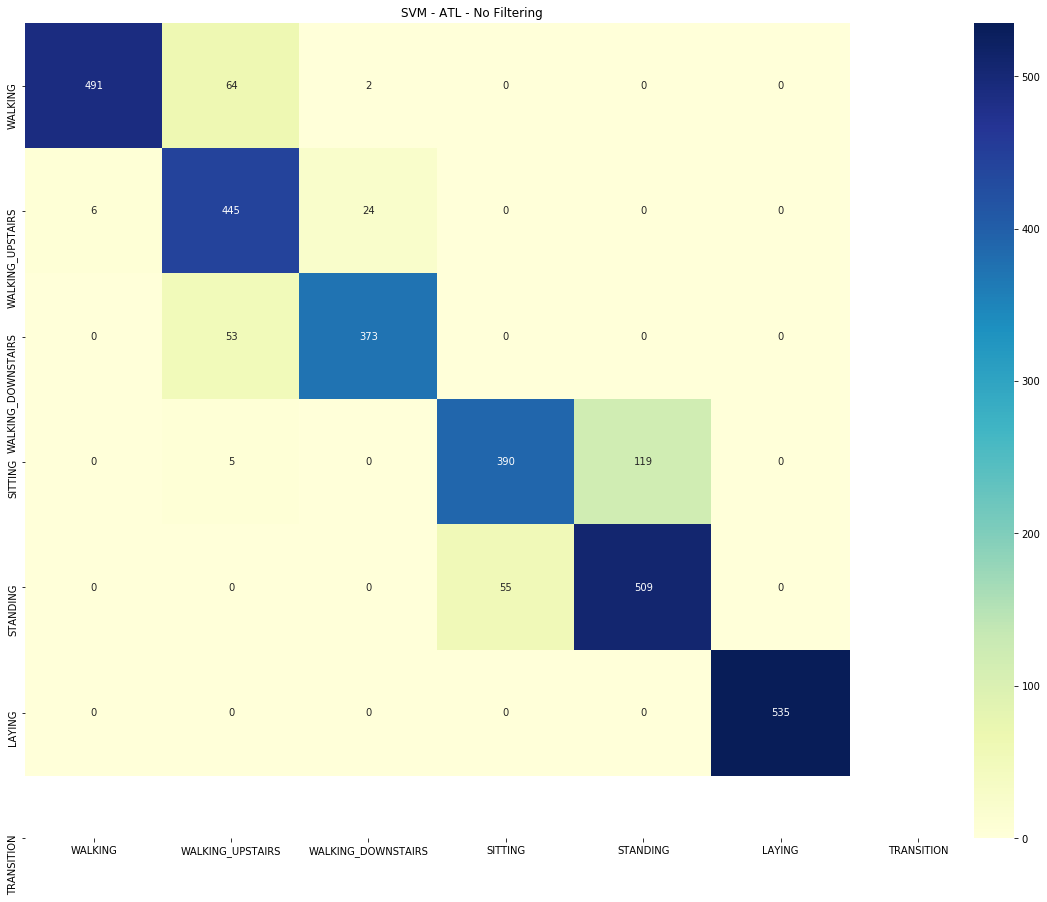

In [311]:
svc_result_conf_mat = met.confusion_matrix(cv_y_test, svc_y_hat)
plt.subplots(figsize=(20,15))
s=seaborn.heatmap(svc_result_conf_mat.astype(int), annot=True, cmap="YlGnBu", fmt='d', xticklabels=ATL_label_names, yticklabels=ATL_label_names)
title="SVM - ATL - No Filtering"
s.set_title(title)

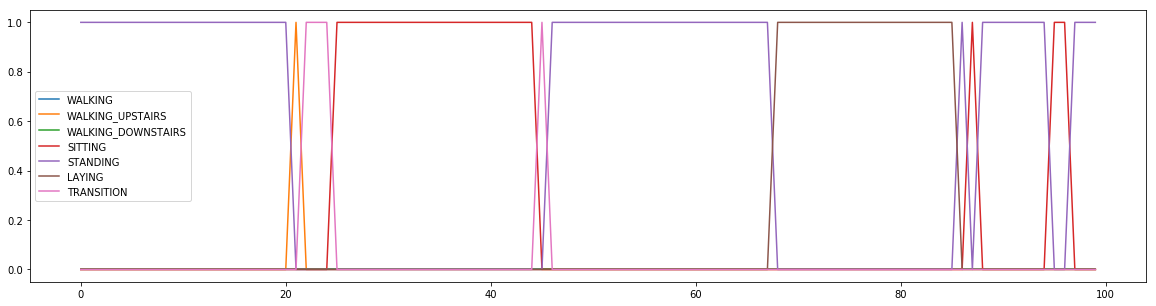

In [107]:
ind_user=X[np.isin(user_ids, [28])]
ind_user=svc_model.predict(ind_user)
ind_y_hat_conv=[]
for l in ind_user:
    empty_label=np.zeros(len(ATL_label_names))
    empty_label[int(l)-1]=1.
    ind_y_hat_conv.append(empty_label)
ind_y_hat_conv=np.vstack(ind_y_hat_conv)
plt.figure(figsize=(20,5))
plt.plot(ind_y_hat_conv[:100])
plt.legend(ATL_label_names)
plt.show()

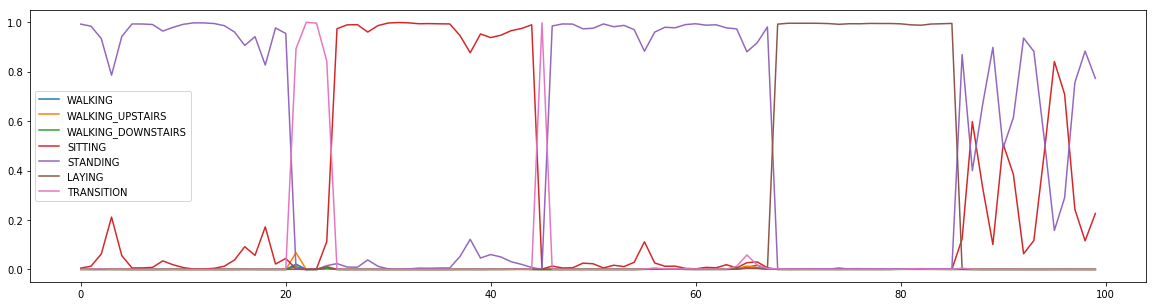

In [108]:
ind_user=X[np.isin(user_ids, [28])]
ind_user=svc_model.predict_proba(ind_user)
ind_y_hat_conv=ind_user
plt.figure(figsize=(20,5))
plt.plot(ind_y_hat_conv[:100])
plt.legend(ATL_label_names, loc='center left')
plt.show()

In [175]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [135]:
def oneD_window(arr, Length=5, Overlap=2):
    windowed=[]
    for begin_idx in range(0, len(arr)-(Length-1), Length-Overlap):
        windowed.append(arr[begin_idx:begin_idx+Length])
    return(windowed)

In [137]:
buffer_idx = oneD_window(range(ind_user.shape[0]), Length=5, Overlap=4)

In [228]:
from collections import deque
from collections import Counter

In [306]:
def TFilter(probabilities, window_length=5):
    buffer_idx = oneD_window(range(probabilities.shape[0]), Length=window_length, Overlap=window_length-1)
    z = deque([-1, -1, -1])
    predictions=[]
    all_new_y_hat_prob = []
    for i in range(window_length-1):
        predictions.append(np.argmax(probabilities[i])+1)
        all_new_y_hat_prob.append(probabilities[i])
    for prob_buffer in buffer_idx:
        y_hat_buffer = probabilities[prob_buffer]
        new_y_hat_prob = np.zeros_like(y_hat_buffer)
        activation_map = np.where(y_hat_buffer>0.2, True, False)
        #print(activation_map.shape)
        for label in activation_map.T:
            try:
                num_cont = max(len(list(v)) for g,v in itertools.groupby(label) if g==True)
                if num_cont < 2:
                    #print(np.where(label==True))
                    activation_map[np.where(label==True)]=False
            except ValueError:
                pass
        for lbl_idx, label_prob in enumerate(y_hat_buffer.T):
            new_y_hat_prob.T[lbl_idx] = savitzky_golay(label_prob, 5, 3)
        #plt.plot(y_hat_buffer)
        #plt.show()
        #plt.plot(new_y_hat_prob)
        #plt.show()
        all_new_y_hat_prob.append(new_y_hat_prob[-1])
        c=np.argmax(new_y_hat_prob[-1])+1
        predictions.append(c)
        '''z.popleft()
        z.append(c)
        most_common,num_most_common = Counter(z).most_common(1)[0]
        if not most_common==-1:
            predictions.append(most_common)'''
            
    return(np.vstack(predictions), np.vstack(all_new_y_hat_prob))

In [281]:
atl_svc_y_hat_prob = svc_model.predict_proba(cv_x_test)

In [296]:
atl_y_hat, atl_y_hat_filtered_prob=TFilter(atl_svc_y_hat_prob, 10)
print(1.-accuracy_score(atl_y_hat, cv_y_test))

(10, 7)
(array([1, 3, 7, 9]),)
(10, 7)
(array([0, 2, 6, 8]),)
(10, 7)
(array([1, 5, 7, 9]),)
(10, 7)
(10, 7)
(10, 7)
(array([9]),)
(10, 7)
(array([8]),)
(10, 7)
(array([7]),)
(10, 7)
(array([6]),)
(10, 7)
(array([5]),)
(10, 7)
(array([4, 9]),)
(10, 7)
(array([3, 8]),)
(10, 7)
(array([2, 7]),)
(10, 7)
(array([1, 6]),)
(10, 7)
(array([0]),)
(array([5]),)
(10, 7)
(array([4]),)
(10, 7)
(array([3]),)
(10, 7)
(array([2, 9]),)
(10, 7)
(array([9]),)
(array([1, 8]),)
(10, 7)
(array([0, 7]),)
(10, 7)
(array([6]),)
(10, 7)
(array([5]),)
(10, 7)
(array([4]),)
(10, 7)
(array([3]),)
(10, 7)
(array([2]),)
(10, 7)
(array([0, 4, 8]),)
(array([1]),)
(10, 7)
(array([3, 7, 9]),)
(array([0]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([9]),)
(10, 7)
(10, 7)
(array([9]),)
(10, 7)
(10, 7)
(array([0]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([0]),)
(10, 7)
(10, 7)
(10, 7)
(array([0]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([9]),)
(10, 7)
(10, 7)
(array([9]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10,

(10, 7)
(array([9]),)
(10, 7)
(array([8]),)
(10, 7)
(array([7, 9]),)
(10, 7)
(array([6, 8]),)
(10, 7)
(array([5, 7]),)
(10, 7)
(array([4, 6]),)
(10, 7)
(array([3, 5]),)
(10, 7)
(array([2, 4]),)
(10, 7)
(array([1, 3]),)
(10, 7)
(array([0, 2]),)
(10, 7)
(array([1]),)
(10, 7)
(array([0]),)
(10, 7)
(10, 7)
(array([9]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([0]),)
(array([9]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([9]),)
(10, 7)
(array([8]),)
(10, 7)
(array([7]),)
(10, 7)
(array([6]),)
(array([0, 4, 9]),)
(10, 7)
(array([5]),)
(10, 7)
(array([4]),)
(10, 7)
(array([3]),)
(10, 7)
(array([2]),)
(10, 7)
(array([1]),)
(10, 7)
(array([0]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([0, 8]),)
(10, 7)
(array([7]),)
(10, 7)
(array([6, 9]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([9]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([0]),)
(a

(10, 7)
(array([1, 4, 9]),)
(array([8]),)
(10, 7)
(array([0, 3, 8]),)
(array([7, 9]),)
(10, 7)
(array([2, 7]),)
(10, 7)
(array([1, 6]),)
(10, 7)
(array([0, 5]),)
(10, 7)
(array([4]),)
(10, 7)
(array([3, 9]),)
(10, 7)
(array([0]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([0, 9]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([0]),)
(10, 7)
(array([9]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([0, 9]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([0]),)
(10, 7)
(array([9]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([9]),)
(10, 7)
(10, 7)
(array([0]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([9]),)
(10, 7)
(array([8]),)
(10, 7)
(array([7]),)
(10, 7)
(array([6]),)
(10, 7)
(array([5]),)
(10, 7)
(array([4]),)
(10, 7)
(array([3]),)
(10, 7)
(array([2]),)
(10, 7)
(array([0]),)
(array([1]),)
(10, 7)
(array(

(10, 7)
(array([5]),)
(10, 7)
(array([4]),)
(10, 7)
(array([3]),)
(10, 7)
(array([2]),)
(10, 7)
(array([1]),)
(10, 7)
(array([0]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([9]),)
(10, 7)
(array([8]),)
(10, 7)
(array([7]),)
(10, 7)
(array([6]),)
(10, 7)
(array([5]),)
(10, 7)
(array([4]),)
(10, 7)
(array([3]),)
(10, 7)
(array([2]),)
(10, 7)
(array([1]),)
(10, 7)
(array([0]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([9]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([0]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([9]),)
(10, 7)
(array([8]),)
(array([9]),)
(10, 7)
(array([7]),)
(array([9]),)
(array([8]),)
(10, 7)
(array([6]),)
(array([7]),)
(10, 7)
(array([5]),)
(array([6]),)
(10, 7)
(array([4]),)
(array([5]),)
(10, 7)
(array([3]),)
(array([4]),)
(10, 7)
(array([2]),)
(array([3]),)
(10, 7)
(array([1]),)
(array([0, 3, 5, 8]),)
(array(

(10, 7)
(array([4, 9]),)
(10, 7)
(array([3, 8]),)
(10, 7)
(array([2, 7]),)
(array([0]),)
(array([9]),)
(10, 7)
(array([1, 6]),)
(array([9]),)
(array([8]),)
(10, 7)
(array([0, 5]),)
(10, 7)
(array([4]),)
(10, 7)
(array([3]),)
(10, 7)
(array([2]),)
(10, 7)
(array([1]),)
(array([0, 2]),)
(10, 7)
(array([0]),)
(array([1]),)
(10, 7)
(array([0]),)
(10, 7)
(10, 7)
(10, 7)
(array([0]),)
(array([9]),)
(10, 7)
(array([9]),)
(array([8]),)
(10, 7)
(array([7]),)
(10, 7)
(array([6]),)
(10, 7)
(array([5]),)
(10, 7)
(array([4, 9]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([0]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([9]),)
(10, 7)
(10, 7)
(10, 7)
(array([9]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([0]),)
(array([1]),)
(10, 7)
(array([0]),)
(10, 7)
(10, 7)
(10, 7)
(array([0]),)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(10, 7)
(array([9]),)
(10, 7)
(array([9]),)
(array([8]),)
(10, 7)
(10, 7)
(10, 7)
(

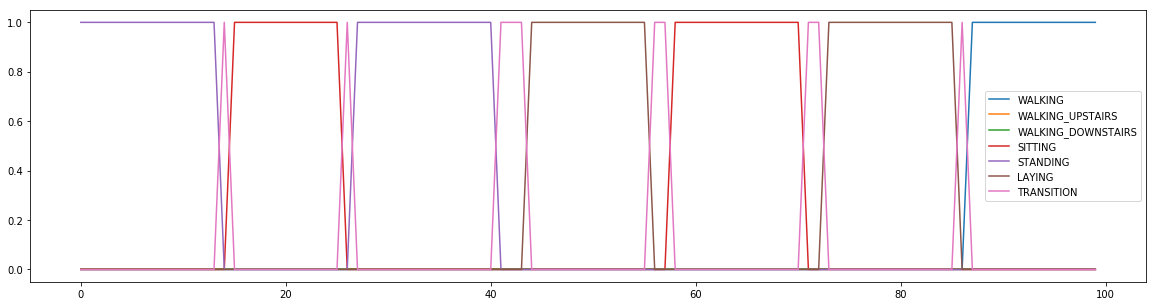

In [288]:
ind_user=cv_y_test
ind_y_conv=[]
for l in ind_user:
    empty_label=np.zeros(len(ATL_label_names))
    empty_label[int(l)-1]=1.
    ind_y_conv.append(empty_label)
ind_y_conv=np.vstack(ind_y_conv)

plt.figure(figsize=(20,5))
plt.plot(ind_y_conv[:100])
plt.legend(ATL_label_names)
plt.show()

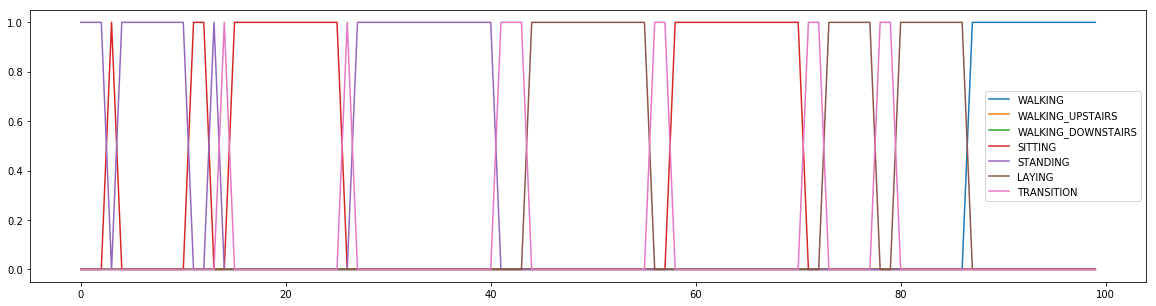

In [297]:
ind_user=atl_y_hat
ind_y_conv=[]
for l in ind_user:
    empty_label=np.zeros(len(ATL_label_names))
    empty_label[int(l)-1]=1.
    ind_y_conv.append(empty_label)
ind_y_conv=np.vstack(ind_y_conv)

plt.figure(figsize=(20,5))
plt.plot(ind_y_conv[:100])
plt.legend(ATL_label_names)
plt.show()

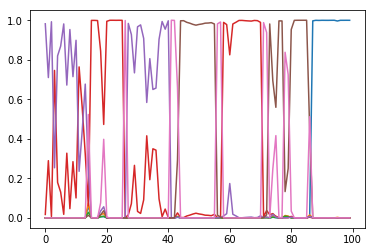

In [283]:
plt.plot(atl_svc_y_hat_prob[:100])
plt.show()

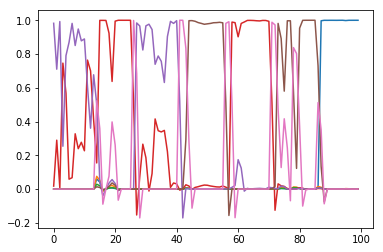

In [284]:
plt.plot(atl_y_hat_filtered_prob[:100])
plt.show()

Text(0.5,1,'SVM - ATL - Filtering')

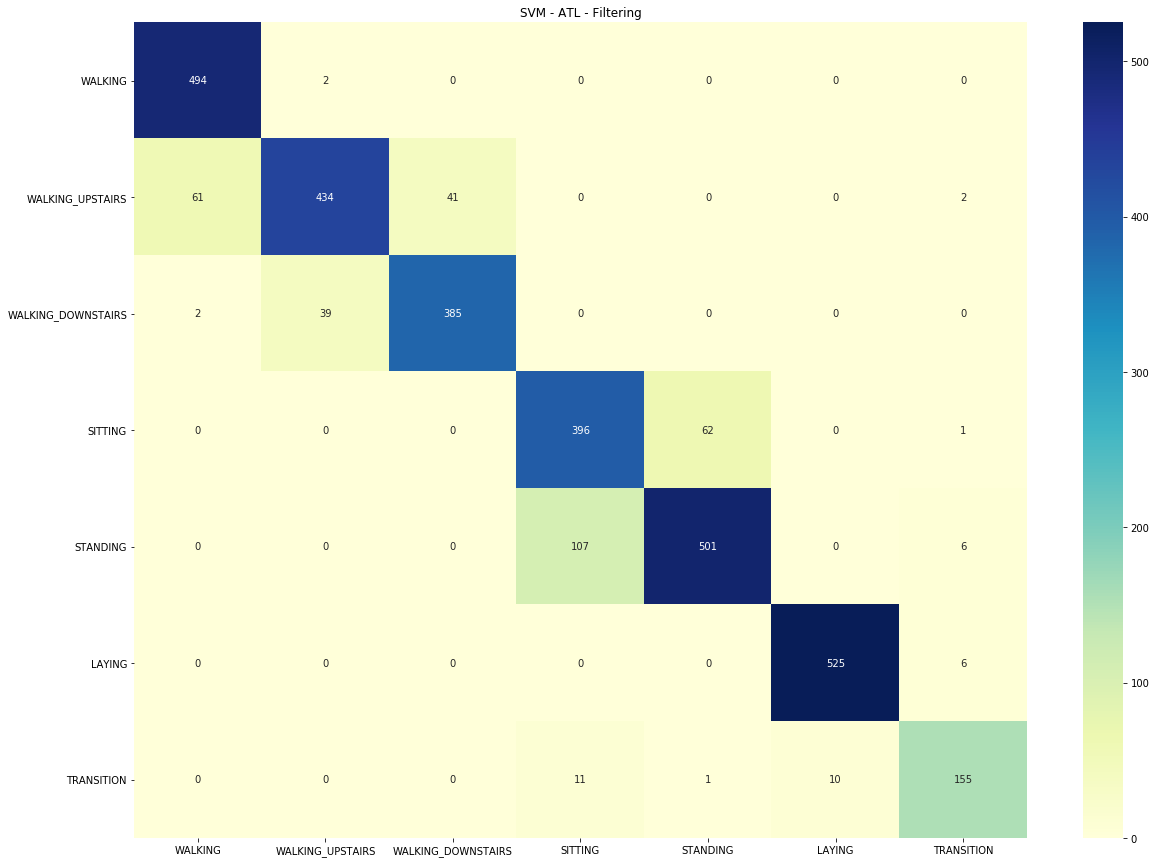

In [299]:
svc_result_conf_mat = met.confusion_matrix(atl_y_hat, cv_y_test)
plt.subplots(figsize=(20,15))
s=seaborn.heatmap(svc_result_conf_mat.astype(int), annot=True, cmap="YlGnBu", fmt='d', xticklabels=ATL_label_names, yticklabels=ATL_label_names)
title="SVM - ATL - Filtering"
s.set_title(title)

In [257]:
print(accuracy_score(predictions, Y_ATL[np.isin(user_ids, [28])]))

0.8531645569620253


In [307]:
for cv_idx, cv_fold in enumerate(rand_uid):
    train_ids, test_ids = cv_fold[:int(0.7*len(cv_fold))], cv_fold[int(0.7*len(cv_fold)):]
    train_idx = np.isin(user_ids, train_ids)[al_idx]
    test_idx = np.isin(user_ids, test_ids)[al_idx]
    cv_x_train = X_al[train_idx]
    cv_y_train = Y_al[train_idx]
    cv_x_test = X_al[test_idx]
    cv_y_test = Y_al[test_idx]
    svc_model=SVC(gamma='auto', probability=True)
    svc_model.fit(cv_x_train, cv_y_train)
    #y_hat = svc_model.predict_proba(cv_x_test)
    svc_y_hat = svc_model.predict(cv_x_test)
    print(1.-accuracy_score(np.round(svc_y_hat), cv_y_test))
    atl_svc_y_hat_prob = svc_model.predict_proba(cv_x_test)
    atl_y_hat, atl_y_hat_filtered_prob=TFilter(atl_svc_y_hat_prob, 10)
    print(1.-accuracy_score(atl_y_hat, cv_y_test))
    #break

0.06860242501595404
0.0676451818761965
0.10120240480961928
0.10688042752171012
0.10677083333333337
0.10677083333333337
0.030794165316045397
0.01944894651539708
0.10680560078150436
0.10550309345490072


Text(0.5,1,'SVM - AL - Filtering')

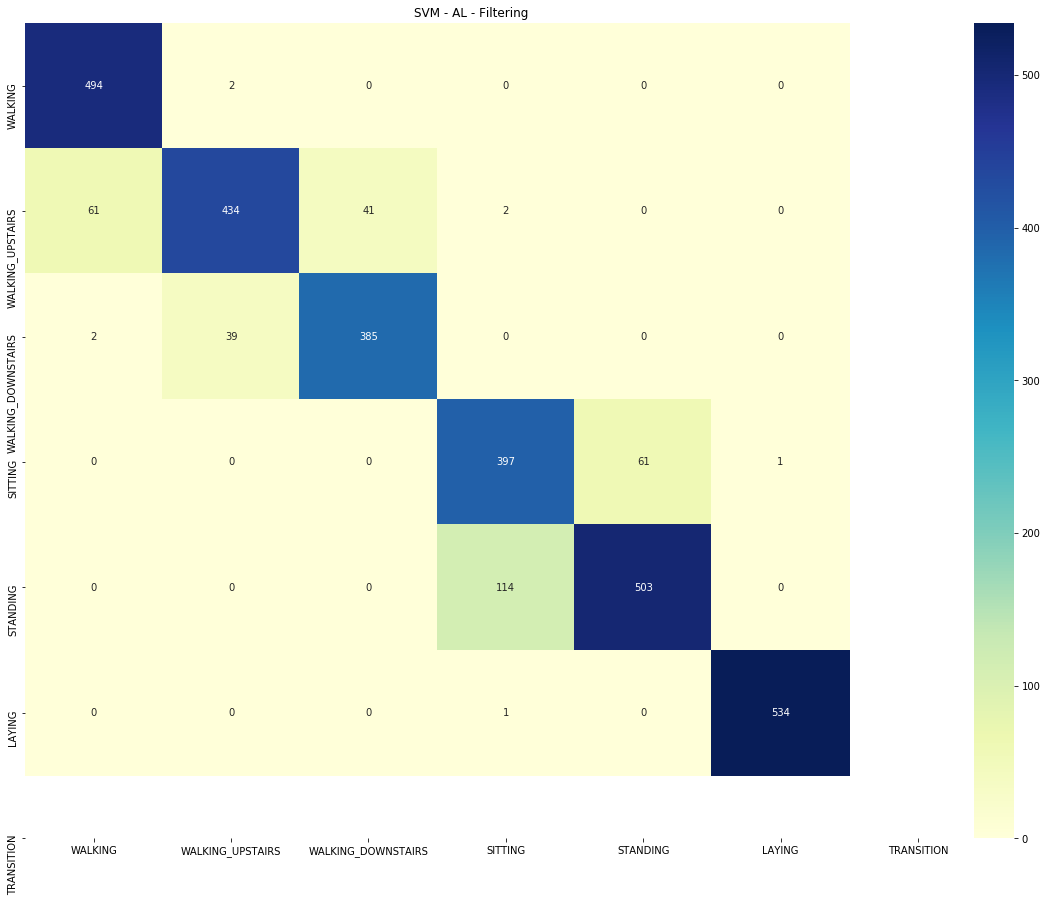

In [302]:
svc_result_conf_mat = met.confusion_matrix(atl_y_hat, cv_y_test)
plt.subplots(figsize=(20,15))
s=seaborn.heatmap(svc_result_conf_mat.astype(int), annot=True, cmap="YlGnBu", fmt='d', xticklabels=ATL_label_names, yticklabels=ATL_label_names)
title="SVM - AL - Filtering"
s.set_title(title)

In [308]:
len(feature_names)

561